# Damped bead on a rotating hoop: SINDy

From Sec. 3.5 in Strogatz.  Full equation:
$$
m R \ddot{\phi} = -b \dot{\phi} - m g \sin \phi + m R \omega^2 \sin \phi \cos \phi
$$

If we introduce nondimensionalizations
$$
\gamma = \frac{R \omega^2}{g} \hspace{2cm} \epsilon = \frac{m^2 g R}{b^2}  \hspace{2cm} T = \frac{b}{mg},
$$
the equation becomes
$$
\epsilon \frac{d^2 \phi}{d \tau^2} = - \frac{d \phi}{d \tau} - \sin \phi + \gamma \sin \phi \cos \phi.
$$
For $\epsilon \ll 1$ and $\gamma = \mathcal{O}(1)$, the system is overdamped and approximately first-order.  The system undergoes a pitchfork bifurcation at $\gamma = 1$.

In [1]:
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

from scipy import linalg
from scipy.integrate import solve_ivp

from sindy import *

# Set up the physical system

$$
m R \ddot{\phi} = -b \dot{\phi} - m g \sin \phi + m R^2 \omega \sin \phi \cos \phi
$$

In [2]:
def make_ode(m, R, b, g, w):
    return lambda t, y: np.array([y[1],
                     (-b*y[1]-m*g*np.sin(y[0])+m*R*w**2*np.sin(y[0])*np.cos(y[0]))/(m*R)])

In [3]:
# Dimension vector: [length, mass, time]
param_list = [
    Quantity('m', [0, 1, 0]),
    Quantity('R', [1, 0, 0]),
    Quantity('b', [1, 1, -1]),
    Quantity('g', [1, 0, -2]),
    Quantity('w', [0, 0, -1], sym_name=r'\omega')
]

qty_list = [
    Quantity('t', [0, 0, 1]),
    Quantity('q', [0, 0, 0])
]

Hoop = System(qty_list, param_list)

# Randomly sample parameters and simulate dynamics

In [4]:
seed = np.random.randint(low=0, high=2**32-1)
seed = 1062360483
print(seed)
rng = np.random.RandomState(seed)

nsamples = 20  # Number of parameter values

t_span = (0, 50)
for j in range(nsamples):
    m = rng.uniform(1, 2)       # Bead mass
    R = rng.uniform(1e-1, 30)   # Radius
    b = rng.uniform(1, 10)      # Damping
    g = 9.8                     # Gravity
    w = rng.uniform(1e-2, 1)    # Natural frequency
    
    # Run simulation
    phi0 = 0.2*rng.randn(2)
    rhs = make_ode(m, R, b, g, w)
    sol = solve_ivp(rhs, t_span, phi0, rtol=1e-8, atol=1e-8)
    phi = sol.y[0, :]
    dphi = sol.y[1, :]
    ddphi = rhs(0, sol.y)[1, :]
    t = sol.t

    Hoop.add_expt(
        q = {'q': (phi, dphi, ddphi), 't': t},
        p = {'m': m, 'R': R, 'b': b, 'g': g, 'w': w}
    )

1062360483


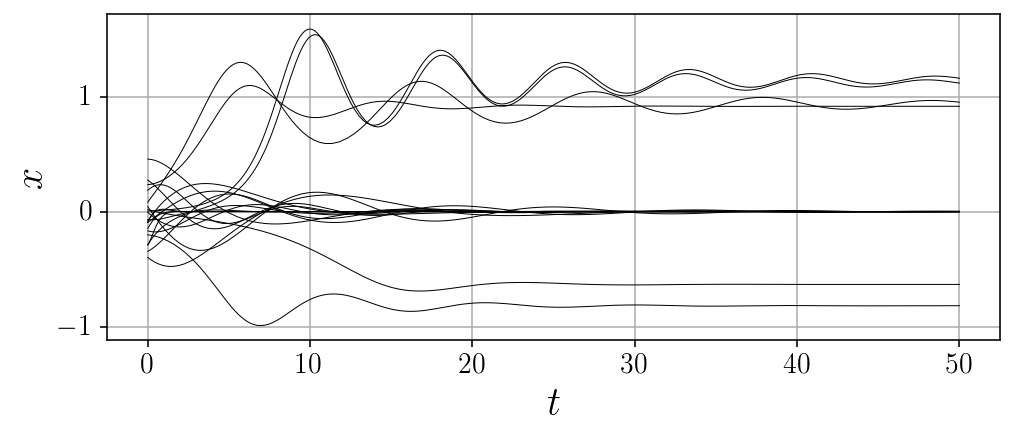

In [5]:
plt.figure(figsize=(8, 3))
for expt in Hoop.expts:
    phi, dphi, ddphi = expt['q']
    t = expt['t']
    plt.plot(t, phi, c='k', lw=0.5)
plt.xlabel(r'$t$')
plt.ylabel(r"$x$")
plt.grid()
plt.show()

# Set up the optimization problem

First, we have to tell the DimensionlessSINDy class how to take the quantities and parameters and turn them into arrays.  In particular, in this case the quantity of interest ($\phi$) is already dimensionless, so we just need to use the timescale to scale the derivatives, so that they are also.

We can also take advantage of the physical symmetry of the system in $\phi$ to cheaply augment our data

In [6]:
def vectorize(expt, pi):
    """
    For a given candidate scaling, generate numpy arrays for
      input vectors (q), scaled derivatives (dq), paramters (p), and relative weights (w)
    """
    T = pi[0]        # Timescale
    phi, dphi, ddphi = expt['q']
    t = expt['t']    # Dimensional time
    
    q = np.vstack([phi, T*dphi])
    dq =  (T**2*ddphi)[None, :]
    
    w = np.ones(len(t))  # No weights in this case, since all simulations are comparable amplitude
    p = np.vstack([ pi[1:] for i in range(len(t)) ]).T  # Each row is a dimensionless parameter
    
    # Symmetrize in phi
    q = np.hstack([q, -q])
    dq = np.hstack([dq, -dq])
    p = np.hstack([p, p])
    w = np.hstack([w, w])
    
    return q, dq, p, w

Next we choose a library of candidate functions

In [7]:
# Define candidate functions
q_fns = [lambda q: q[1],
         lambda q: q[0],
         lambda q: q[0]**2,
         lambda q: q[0]**3,
         lambda q: q[0]**4,
         lambda q: q[0]**5,
         lambda q: q[0]**6,
         lambda q: q[0]**7
        ]

p_fns = [lambda pi: 1+0*pi[0],
         lambda pi: pi[0],
         lambda pi: pi[1]]

Theta = ParametricLibrary(q_fns, p_fns)

In [8]:
opt = STLSQ(threshold=0.0, cond=None, max_iter=1, normalize=True)
model = DimensionlessSINDy(Hoop, Theta, vectorize, opt=opt)

param_list, param_names, loss_list = model.fit_all_dynamics(loss=l2_loss, num_nondim=2)

In [9]:
from IPython.display import display, Math
sort_idx = np.argsort(loss_list)

for i in range(5):
    display(Math(sym.latex(param_names[sort_idx[i]])))
    print('test loss = ', loss_list[sort_idx[i]])
    print('----------------------------')

<IPython.core.display.Math object>

test loss =  0.0004064174579662564
----------------------------


<IPython.core.display.Math object>

test loss =  0.0030303006749675798
----------------------------


<IPython.core.display.Math object>

test loss =  0.08224444952034647
----------------------------


<IPython.core.display.Math object>

test loss =  0.09466508532023114
----------------------------


<IPython.core.display.Math object>

test loss =  0.11593281127170371
----------------------------


Text(0, 0.5, 'SINDy loss')

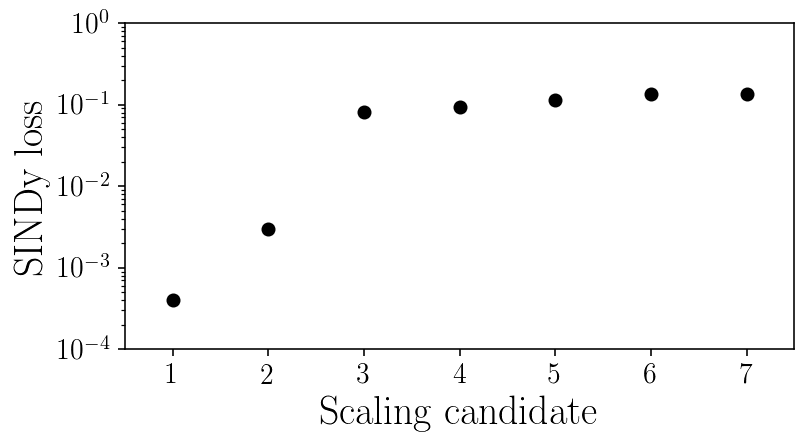

In [10]:
plt.figure(figsize=(6, 3))
plt.scatter(1+np.arange(len(loss_list)), loss_list[sort_idx], c='k')
plt.gca().set_yscale('log')
plt.xlim([0.5, 7.5])
plt.ylim([1e-4, 1e0])
plt.xlabel('Scaling candidate')
plt.ylabel('SINDy loss')

Repeat for the best solution

In [11]:
model_idx = 0
dim_vecs = param_list[sort_idx[model_idx]]
q, dq, p, w = model.vectorize_all(dim_vecs)

lib = Theta(q, p)

# Fit SINDy model
# Cubic model
opt.threshold=1e-1
opt.max_iter=5
opt.fit(lib, dq.T)
Xi3 = opt.coef_[0, :]

# Septic model
opt.threshold=1e-3
opt.fit(lib, dq.T)
Xi7 = opt.coef_[0, :]

In [12]:
lib = Theta(sym.symbols('q, \dot{q}'), sym.symbols('\pi_1, \pi_2')).flatten('F')
expr = lib @ Xi3
display(expr)

print('----')

expr = lib @ Xi7
display(expr)

-0.957510820652731*\dot{q}*\pi_1 - 0.944237067097657*\pi_1*q - 0.339896888578043*\pi_2*q**3 + 0.864192382865953*\pi_2*q

----


-0.999867169032651*\dot{q}*\pi_1 - 0.00636115179353635*\pi_1*q**5 + 0.164356228947495*\pi_1*q**3 - 0.999763939640866*\pi_1*q - 0.00938430681265643*\pi_2*q**7 + 0.127193034462358*\pi_2*q**5 - 0.662436420924279*\pi_2*q**3 + 0.999418233852709*\pi_2*q

### Evaluate model for out-of-sample parameters

In [13]:
# Difficult test case
m = 1.95
R = 35
b = 2.00
g = 9.8
w = 0.58
p_vec = np.vstack([m, R, b, g, w]).T

In [14]:
# gamma, eps, T, for comparison
R*w**2/g, m**2*g*R/b**2, b/m*g

(1.2014285714285713, 326.064375, 10.051282051282053)

In [15]:
Pi_q = np.exp( np.log(p_vec) @ np.vstack(dim_vecs[1:]).T ).T
Pi_t = np.exp( np.log(p_vec) @ dim_vecs[0] ).T  # Timescale

q_sym = sym.symbols('q, \dot{q}')
lib = Theta(q_sym, Pi_q).flatten('F')

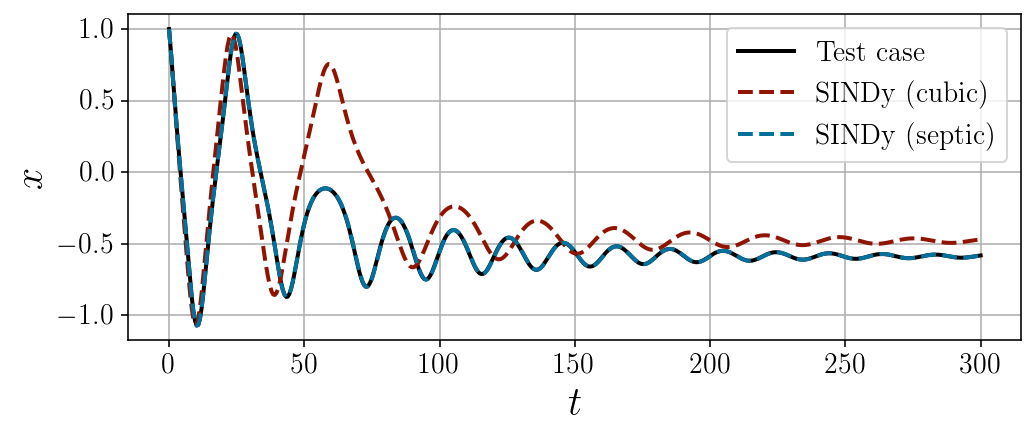

In [16]:
t = np.linspace(0, 300, 500) # Dimensional time
t_span = (t[0], t[-1])
phi0_test = [1.0, -0.2]
phi0_nondim = phi0_test.copy()
phi0_nondim[1] *= Pi_t

rhs = make_ode(m, R, b, g, w)
sol = solve_ivp(rhs, t_span, phi0_test, t_eval=t, rtol=1e-8, atol=1e-8)
phi_test = sol.y[0, :]

rhs_sindy = sym.lambdify(q_sym, lib @ Xi3)
sol = solve_ivp(lambda t, y: np.array([y[1], rhs_sindy(*y)]),
                t_span/Pi_t, phi0_nondim, t_eval=t/Pi_t, rtol=1e-8, atol=1e-8)
phi_sindy3 = sol.y[0, :]

rhs_sindy = sym.lambdify(q_sym, lib @ Xi7)
sol = solve_ivp(lambda t, y: np.array([y[1], rhs_sindy(*y)]),
             t_span/Pi_t, phi0_nondim, t_eval=t/Pi_t, rtol=1e-8, atol=1e-8)
phi_sindy7 = sol.y[0, :]

plt.figure(figsize=(8, 3))
plt.plot(t, phi_test, c='k', lw=2, label='Test case')
plt.plot(t, phi_sindy3, lw=2, ls='--', label='SINDy (cubic)', c='xkcd:brick red')
plt.plot(t, phi_sindy7, lw=2, ls='--', label='SINDy (septic)', c='xkcd:ocean blue')
plt.legend(fontsize=14)
plt.xlabel("$t$")
plt.ylabel(r"$x$")
plt.grid()